In [1]:
# import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pickle
import re
import subprocess
from bs4 import BeautifulSoup


In [2]:
# select past season to use as test set

pastSeason = 2024  # based on when the season concludes
rootDirectory = '/Users/dthomas/Desktop/Coding/NCAAB/Latest_Commit'

# do not edit
seasons_start_date_df = pd.read_csv(rootDirectory + '/Data/Season_Start_Dates.csv')
seasonStartDate_obj = datetime.strptime(seasons_start_date_df.loc[seasons_start_date_df['Season'] == pastSeason, 'DayZero'].item(), "%m/%d/%Y")
seasonStartDate_str = str(seasonStartDate_obj.year) + '-' + ('0' + str(seasonStartDate_obj.month))[-2:] + '-' + ('0' + str(seasonStartDate_obj.day))[-2:]


In [3]:
# set root directory
rootDirectory = '/Users/dthomas/Desktop/Coding/NCAAB/Latest_Commit'


In [4]:
# team ID conversion dictionaries

massey_conversion_df = pd.read_csv(rootDirectory + '/Data/Team_Name_Conversion.csv')
massey_id_to_espn_name_dict = dict(zip(massey_conversion_df.dropna(subset=['Massey URL'])['Massey URL'], massey_conversion_df.dropna(subset=['Massey URL'])['ESPN Team Name']))
scores_and_odds_name_to_espn_name_dict = dict(zip(massey_conversion_df.dropna(subset=['ScoresAndOdds Name'])['ScoresAndOdds Name'], massey_conversion_df.dropna(subset=['ScoresAndOdds Name'])['ESPN Team Name']))
sportsbook_reviews_name_to_espn_name_dict = dict(zip(massey_conversion_df.dropna(subset=['Sportsbook Reviews Name'])['Sportsbook Reviews Name'], massey_conversion_df.dropna(subset=['Sportsbook Reviews Name'])['ESPN Team Name']))


In [5]:
# necessary functions

def scrape_scores_and_odds(date_string):
    '''
    Input: a string in the form YYYY-MM-DD
    Output: a DataFrame containing the moneyline odds for all games on the given date
    '''
    url = f'https://www.scoresandodds.com/ncaab?date={date_string}'
    result = subprocess.run(['curl', url], capture_output=True, text=True)

    # Raw HTML content
    html_content = result.stdout
    
    # Parse the HTML content
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find all game rows
    games = soup.find_all('tr', class_='event-card-row')

    # Initialize an empty list to store the game data
    game_data = []

    for game in games:
        # Check if the game has been canceled
        header_tag = game.find_previous('tr', class_='event-card-header')
        if header_tag and 'CANCELED' in header_tag.get_text():
            continue  # Skip this game if it's canceled

        # Try to find the team name
        team_name_tag = game.find('a', href=True)
        if team_name_tag:
            team_name = team_name_tag.get_text(strip=True)
            # Remove any ranking from the team name using regex
            team_name = re.sub(r'\s*\(\d*?\)', '', team_name)
        else:
            team_name = "Unknown Team"

        # Try to find the moneyline odds
        moneyline_tag = game.find('td', class_='event-card-moneyline')
        if moneyline_tag:
            moneyline_value_tag = moneyline_tag.find('span', class_='data-value')
            if moneyline_value_tag:
                moneyline = moneyline_value_tag.get_text(strip=True)
            else:
                moneyline = "No Odds Listed"
        else:
            moneyline = "No Odds Listed"

        # Append the results to the game_data list
        game_data.append({
            'team_name': team_name,
            'moneyline': moneyline,
            'type': 'Home' if 'home' in game.get('data-side', '') else 'Away'
        })

    # Create a DataFrame from the game data
    moneyline_df = pd.DataFrame(game_data)

    # Create a game_id column based on the index to serve as a unique identifier for each game
    moneyline_df['game_id'] = moneyline_df.index // 2 + 1

    # Set the multi-index with game_id and type (Home/Away)
    moneyline_df.set_index(['game_id', 'type'], inplace=True)

    # Convert to ESPN team names
    moneyline_df['team_name'] = moneyline_df['team_name'].map(scores_and_odds_name_to_espn_name_dict)
    
    # Eliminate duplicate names
    # Step 1: Identify all duplicate team names
    duplicate_team_names = moneyline_df[moneyline_df.duplicated(subset=['team_name'], keep=False)]

    # Step 2: Identify rows to delete (where 'team_name' is duplicated AND 'moneyline' is an empty string)
    rows_to_drop = duplicate_team_names[duplicate_team_names['moneyline'] == '']

    # Step 3: Drop these rows from the original DataFrame
    moneyline_df = moneyline_df.drop(rows_to_drop.index)
    
    return moneyline_df



def calculate_implied_probability(moneyline):
    try:
        moneyline = int(moneyline)
    except:
        return 'Odds Unknown'
    if moneyline > 0:
        return 100 / (moneyline + 100)
    else:
        return -moneyline / (-moneyline + 100)

In [6]:
# read in training data from chosen past season
data = pd.read_csv(rootDirectory + f'/Data/Training_Data/Training_Data_{pastSeason}.csv')
X_test = data.iloc[:, 5:]


In [7]:
# scale and reduce prediction data

# load scaler
# with open(rootDirectory + 'Data/Scaling_and_Reduction_Objects/standard_scaler.pkl', 'rb') as file:
#     standard_scaler = pickle.load(file)

# holding out 2023-24 as test set
# load scaler
with open(rootDirectory + '/Data/Scaling_and_Reduction_Objects/standard_scaler_thru_2022.pkl', 'rb') as file:
    standard_scaler = pickle.load(file)

# slice out the 'HomeAdv A' column (this won't be scaled) 
X_test_unscaled = X_test.iloc[:, 1:]

# scale the data
X_test_scaled = standard_scaler.transform(X_test_unscaled)

# add back the column names
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_unscaled.columns)

# add back the HomeAdv A' column (which was not scaled)
X_test_scaled = pd.concat([X_test.iloc[:, 0].reset_index(drop=True), X_test_scaled.reset_index(drop=True)], axis=1)
# print(f'shape before PCA: {X_test.shape}')


# load PCA object
# with open(rootDirectory + 'Data/Scaling_and_Reduction_Objects/pca_object.pkl', 'rb') as file:
#     pca_object = pickle.load(file)

# holding out 2023-24 as test set
# load PCA object
with open(rootDirectory + '/Data/Scaling_and_Reduction_Objects/pca_object_thru_2022.pkl', 'rb') as file:
    pca_object = pickle.load(file)


# reduce prediction data
X_test = pca_object.transform(X_test_scaled)
# print(f'shape after PCA: {X_test.shape}')


# load RFECV selected indeces
with open(rootDirectory + '/Data/Scaling_and_Reduction_Objects/RFECV_selected_indices.pkl', 'rb') as file:
    selected_indices = pickle.load(file)

X_test = X_test[:, selected_indices]





In [8]:
# make predictions

# load model
with open(rootDirectory + '/Models/final_model.pkl', 'rb') as file:
    model = pickle.load(file)

# make predictions
preds = model.predict_proba(X_test)
preds = pd.DataFrame(preds, columns=['Team B Predicted Prob', 'Team A Predicted Prob'])

# get game dates
dates = data.loc[:, ['Season', 'DayNum']]
dates['Date'] = dates['DayNum'].apply(lambda x: (seasonStartDate_obj + timedelta(days=x)).strftime('%Y-%m-%d'))

# get actual results
actual_results = pd.DataFrame()
actual_results['Actual Result: Team A Wins'] = data.loc[:, 'TeamAWins']

# get team names
teams = data.loc[:, ['TeamID A', 'TeamID B']].rename(columns={'TeamID A': 'Team A', 'TeamID B': 'Team B'})
teams['Team A'] = teams['Team A'].map(massey_id_to_espn_name_dict)
teams['Team B'] = teams['Team B'].map(massey_id_to_espn_name_dict)

# display predictions
predictions_df = pd.concat(
    [dates['Season'].astype('int'), 
     dates['Date'], 
     teams['Team A'], 
     preds['Team A Predicted Prob'], 
     teams['Team B'], 
     preds['Team B Predicted Prob'], 
     actual_results['Actual Result: Team A Wins']], axis=1)
# predictions_df


In [9]:
# get moneyline odds from ScoresAndOdds

# try to read in previously-scraped odds
try:
    with open(rootDirectory + '/Data/Moneyline_Data/moneyline_dict_' + str(pastSeason) + '.pkl', 'rb') as file:
        moneyline_dict = pickle.load(file)

# scrape odds if not yet scraped
except FileNotFoundError:        
    # initialize dictionary to store odds
    moneyline_dict = {}

    # iterate through each gamedate for which predictions were made
    count = 0
    num_games = len(predictions_df['Date'].unique())
    for date_str in predictions_df['Date'].unique():
        moneyline_dict[date_str] = scrape_scores_and_odds(date_str)
        count += 1
        print(f'{count} of {num_games} dates scraped.')
        
    # write scraped odds
    with open(rootDirectory + '/Data/Moneyline_Data/moneyline_dict_' + str(pastSeason) + '.pkl', 'wb') as f:
        pickle.dump(moneyline_dict, f)


In [10]:
# get moneyline odds from Sportsbook Reviews data

def parse_sportsbook_reviews_csv(date_string):
    '''
    Input: 
        - date_string: a string in the form YYYY-MM-DD
    Output: a DataFrame containing the moneyline odds for all games on the given date
    '''
    # Extract MMDD from the date_string
    mmdd_string = date_string[5:7] + date_string[8:10]

    # Determine what season this is
    if int(date_string[5:7]) > 7:
        season = str(int(date_string[0:4]) + 1)
    else:
        season = date_string[0:4]
    
    # Load the CSV into a DataFrame
    df = pd.read_csv(rootDirectory + '/Data/Moneyline_Data/moneyline-raw-' + season + '.csv')
    
    # Filter rows by the mmdd_string
    df_filtered = df.loc[df['Date'] == int(mmdd_string)].copy()

    # Map team names to ESPN names and rename the column to 'team_name'
    df_filtered['team_name'] = df_filtered['Team'].map(sportsbook_reviews_name_to_espn_name_dict)
    
    # Initialize an empty list to store the game data
    game_data = []

    # Iterate through the filtered DataFrame
    for _, row in df_filtered.iterrows():
        team_name = row['team_name']
        moneyline = row['ML']
        type_ = 'Home' if row['VH'] == 'H' else 'Away'
        
        # Append the results to the game_data list
        game_data.append({
            'team_name': team_name,
            'moneyline': moneyline,
            'type': type_
        })

    # Create a DataFrame from the game data
    moneyline_df = pd.DataFrame(game_data)

    # Ensure 'type' is present before setting the index
    if 'type' in moneyline_df.columns:
        # Create a game_id column based on the index to serve as a unique identifier for each game
        moneyline_df['game_id'] = moneyline_df.index // 2 + 1

        # Set the multi-index with game_id and type (Home/Away)
        moneyline_df.set_index(['game_id', 'type'], inplace=True)
    else:
        return

    return moneyline_df

# get moneyline odds from Sportsbook Reviews data

# try to read in previously-scraped odds
try:
    with open(rootDirectory + '/Data/Moneyline_Data/moneyline_dict_' + str(pastSeason) + '.pkl', 'rb') as file:
        moneyline_dict = pickle.load(file)

# scrape odds if not yet scraped
except FileNotFoundError:        
    # initialize dictionary to store odds
    moneyline_dict = {}

    # iterate through each gamedate for which predictions were made
    count = 0
    num_games = len(predictions_df['Date'].unique())
    for date_str in predictions_df['Date'].unique():
        moneyline_dict[date_str] = parse_sportsbook_reviews_csv(date_str)
        count += 1
        print(f'{count} of {num_games} dates scraped.')
        
    # write scraped odds
    with open(rootDirectory + '/Data/Moneyline_Data/moneyline_dict_' + str(pastSeason) + '.pkl', 'wb') as f:
        pickle.dump(moneyline_dict, f)


In [11]:
# add moneyline columns to predictions DataFrame
predictions_df['Team A Moneyline'] = ''
predictions_df['Team B Moneyline'] = ''

# iterate through each predicted game
count = 0
for index in range(len(predictions_df)):
    # check that moneyline odds exist for this date
    if moneyline_dict[predictions_df.loc[index, 'Date']] is None:
        continue
    
    # select the moneyline DataFrame for the corresponding date
    moneyline_df = moneyline_dict[predictions_df.loc[index, 'Date']].reset_index()
    
    # check that both teams appear in moneyline DataFrame from ScoresAndOdds
    if predictions_df.loc[index, 'Team A'] not in moneyline_df['team_name'].values or predictions_df.loc[index, 'Team B'] not in moneyline_df['team_name'].values:
        # record Team A's moneyline as missing
        predictions_df.loc[index, 'Team A Moneyline'] = 'No Odds Listed'
        # record Team B's moneyline as missing
        predictions_df.loc[index, 'Team B Moneyline'] = 'No Odds Listed'
    
    else:
        # record Team A's moneyline
        predictions_df.loc[index, 'Team A Moneyline'] = moneyline_df.loc[moneyline_df['team_name'] == predictions_df.loc[index, 'Team A'], 'moneyline'].item()
        # record Team B's moneyline
        predictions_df.loc[index, 'Team B Moneyline'] = moneyline_df.loc[moneyline_df['team_name'] == predictions_df.loc[index, 'Team B'], 'moneyline'].item()
        # count game
        count += 1
        
print(f'Moneyline data recorded for {count} out of {len(predictions_df)} predicted games.')

# Calculate implied odds
predictions_df['Team A Implied Prob'] = predictions_df['Team A Moneyline'].apply(calculate_implied_probability)
predictions_df['Team B Implied Prob'] = predictions_df['Team B Moneyline'].apply(calculate_implied_probability)

# Clean up predictions DataFrame
predictions_df.loc[predictions_df['Team A Moneyline'] == '', 'Team A Moneyline'] = 'No Odds Listed'
predictions_df.loc[predictions_df['Team B Moneyline'] == '', 'Team B Moneyline'] = 'No Odds Listed'
columns_order = [
    'Season', 'Date', 'Actual Result: Team A Wins',
    'Team A', 'Team A Moneyline', 'Team A Implied Prob', 'Team A Predicted Prob', 
    'Team B', 'Team B Moneyline', 'Team B Implied Prob', 'Team B Predicted Prob']
predictions_df = predictions_df[columns_order]

# predictions_df


Moneyline data recorded for 4599 out of 4600 predicted games.


In [12]:
# set bet confidence threshold
# difference between predicted probability and Moneyline implied odds probability
# bets will only be placed on lines that exceed this threshold

threshold = 0.25  


In [13]:
# calculate profit/loss for all bets placed

# set threshold probability difference to place a bet
# threshold = 0.20

# set bet amount
bet_amount = 1

# create new rows for bets
predictions_df['Team A Bet Amount'] = 0.0
predictions_df['Team A Profit/Loss'] = 0.0
predictions_df['Team B Bet Amount'] = 0.0
predictions_df['Team B Profit/Loss'] = 0.0
predictions_df['Bet Amount'] = 0.0
predictions_df['Profit/Loss'] = 0.0

# iterate through each predicted game
for index in range(len(predictions_df)):
    # if Team A moneyline exists
    if isinstance(predictions_df.loc[index, 'Team A Implied Prob'], float):
        # if Team A's predicted probability is higher than implied probability by more than the threshold difference
        if predictions_df.loc[index, 'Team A Predicted Prob'] > predictions_df.loc[index, 'Team A Implied Prob'] + threshold:
            # place a bet on Team A
            predictions_df.loc[index, 'Team A Bet Amount'] = bet_amount
            # if Team A actually won
            if predictions_df.loc[index, 'Actual Result: Team A Wins']:
                # calculate profit
                # if positive moneyline
                if int(predictions_df.loc[index, 'Team A Moneyline']) > 0:
                    predictions_df.loc[index, 'Team A Profit/Loss'] = predictions_df.loc[index, 'Team A Bet Amount'] * int(predictions_df.loc[index, 'Team A Moneyline']) / 100
                # if negative moneyline
                elif int(predictions_df.loc[index, 'Team A Moneyline']) < 0:
                    predictions_df.loc[index, 'Team A Profit/Loss'] = -predictions_df.loc[index, 'Team A Bet Amount'] * 100 / int(predictions_df.loc[index, 'Team A Moneyline'])
            # if Team A actually lost
            else:
                # calculate amount lost
                predictions_df.loc[index, 'Team A Profit/Loss'] = -predictions_df.loc[index, 'Team A Bet Amount']
        # if Team A's predicted probability is not higher than implied probability
        else:
            # don't place a bet on Team A
            predictions_df.loc[index, 'Team A Bet Amount'] = 0
            predictions_df.loc[index, 'Team A Profit/Loss'] = 0
    # if Team A moneyine does not exist
    else:
        # don't place a bet on Team A
        predictions_df.loc[index, 'Team A Bet Amount'] = 0
        predictions_df.loc[index, 'Team A Profit/Loss'] = 0

    # if Team B moneyline exists
    if isinstance(predictions_df.loc[index, 'Team B Implied Prob'], float):
        # if Team B's predicted probability is higher than implied probability by more than the threshold difference
        if predictions_df.loc[index, 'Team B Predicted Prob'] > predictions_df.loc[index, 'Team B Implied Prob'] + threshold:
            # place a bet on Team B
            predictions_df.loc[index, 'Team B Bet Amount'] = bet_amount
            # if Team B actually won
            if not predictions_df.loc[index, 'Actual Result: Team A Wins']:
                # calculate profit
                # if positive moneyline
                if int(predictions_df.loc[index, 'Team B Moneyline']) > 0:
                    predictions_df.loc[index, 'Team B Profit/Loss'] = predictions_df.loc[index, 'Team B Bet Amount'] * int(predictions_df.loc[index, 'Team B Moneyline']) / 100
                # if negative moneyline
                elif int(predictions_df.loc[index, 'Team B Moneyline']) < 0:
                    predictions_df.loc[index, 'Team B Profit/Loss'] = -predictions_df.loc[index, 'Team B Bet Amount'] * 100 / int(predictions_df.loc[index, 'Team B Moneyline'])
            # if Team B actually lost
            else:
                # calculate amount lost
                predictions_df.loc[index, 'Team B Profit/Loss'] = -predictions_df.loc[index, 'Team B Bet Amount']
        # if Team B's predicted probability is not higher than implied probability
        else:
            # don't place a bet on Team B
            predictions_df.loc[index, 'Team B Bet Amount'] = 0
            predictions_df.loc[index, 'Team B Profit/Loss'] = 0
    # if Team B moneyine does not exist
    else:
        # don't place a bet on Team B
        predictions_df.loc[index, 'Team B Bet Amount'] = 0
        predictions_df.loc[index, 'Team B Profit/Loss'] = 0
    
    # consolidate bets into single column, profit/loss into single column
    predictions_df.loc[index, 'Bet Amount'] = predictions_df.loc[index, 'Team A Bet Amount'] + predictions_df.loc[index, 'Team B Bet Amount']
    predictions_df.loc[index, 'Profit/Loss'] = predictions_df.loc[index, 'Team A Profit/Loss'] + predictions_df.loc[index, 'Team B Profit/Loss']

    # calculate running total profit/loss
    predictions_df['Total Profit/Loss'] = predictions_df['Profit/Loss'].cumsum()
    
# reorder columns
columns_order = [
    'Season', 'Date', 'Actual Result: Team A Wins',
    'Team A', 'Team A Moneyline', 'Team A Implied Prob', 'Team A Predicted Prob', 'Team A Bet Amount', 'Team A Profit/Loss', 
    'Team B', 'Team B Moneyline', 'Team B Implied Prob', 'Team B Predicted Prob', 'Team B Bet Amount', 'Team B Profit/Loss', 
    'Bet Amount', 'Profit/Loss', 'Total Profit/Loss']
predictions_df = predictions_df[columns_order]

# print season-long profit/loss
print('Total Bet Amount:', round(predictions_df['Bet Amount'].sum(), 2))
print('Total Profit/Loss:', round(predictions_df['Profit/Loss'].sum(), 2))
print('Profit/Loss per Dollar Bet:', round(predictions_df['Profit/Loss'].sum() / predictions_df['Bet Amount'].sum(), 2))


Total Bet Amount: 148.0
Total Profit/Loss: -32.48
Profit/Loss per Dollar Bet: -0.22


In [14]:
# display all individual bets
predictions_df.loc[predictions_df['Bet Amount'] > 0, :]

# display lost bets
print('Lost ' + str(predictions_df.loc[predictions_df['Profit/Loss'] < 0, :].count()['Profit/Loss']) + ' out of ' + str(predictions_df.loc[predictions_df['Bet Amount'] > 0, :].count()['Bet Amount']) + ' bets.')
predictions_df.loc[predictions_df['Profit/Loss'] < 0, :]

# display all bets        
predictions_df.loc[predictions_df['Bet Amount'] > 0, :]


Lost 104 out of 148 bets.


,Season,Date,Actual Result: Team A Wins,Team A,Team A Moneyline,Team A Implied Prob,Team A Predicted Prob,Team A Bet Amount,Team A Profit/Loss,Team B,Team B Moneyline,Team B Implied Prob,Team B Predicted Prob,Team B Bet Amount,Team B Profit/Loss,Bet Amount,Profit/Loss,Total Profit/Loss
18,2024,2023-11-24,True,Oklahoma Sooners,+106,0.485437,0.737073,1.0,1.060000,USC Trojans,-128,0.561404,0.262927,0.0,0.0,1.0,1.060000,1.060000
20,2024,2023-11-24,True,Villanova Wildcats,-154,0.606299,0.201720,0.0,0.000000,Memphis Tigers,+128,0.438596,0.798280,1.0,-1.0,1.0,-1.000000,0.060000
48,2024,2023-11-26,True,Denver Pioneers,+138,0.420168,0.740482,1.0,1.380000,Texas A&M-Commerce Lions,-170,0.62963,0.259518,0.0,0.0,1.0,1.380000,1.440000
49,2024,2023-11-26,False,Virginia Tech Hokies,+132,0.431034,0.682142,1.0,-1.000000,Florida Atlantic Owls,-160,0.615385,0.317858,0.0,0.0,1.0,-1.000000,0.440000
60,2024,2023-11-26,True,Rhode Island Rams,+198,0.33557,0.609633,1.0,1.980000,Yale Bulldogs,-245,0.710145,0.390367,0.0,0.0,1.0,1.980000,2.420000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4517,2024,2024-03-14,False,California Baptist Lancers,+245,0.289855,0.554391,1.0,-1.000000,Seattle U Redhawks,-310,0.756098,0.445609,0.0,0.0,1.0,-1.000000,-32.568845
4518,2024,2024-03-14,True,South Carolina Gamecocks,-240,0.705882,0.304877,0.0,0.000000,Arkansas Razorbacks,+195,0.338983,0.695123,1.0,-1.0,1.0,-1.000000,-33.568845
4519,2024,2024-03-14,False,Loyola Chicago Ramblers,-156,0.609375,0.186048,0.0,0.000000,St. Bonaventure Bonnies,+130,0.434783,0.813952,1.0,1.3,1.0,1.300000,-32.268845
4550,2024,2024-03-15,True,Kent State Golden Flashes,-126,0.557522,0.809558,1.0,0.793651,Bowling Green Falcons,+105,0.487805,0.190442,0.0,0.0,1.0,0.793651,-31.475194


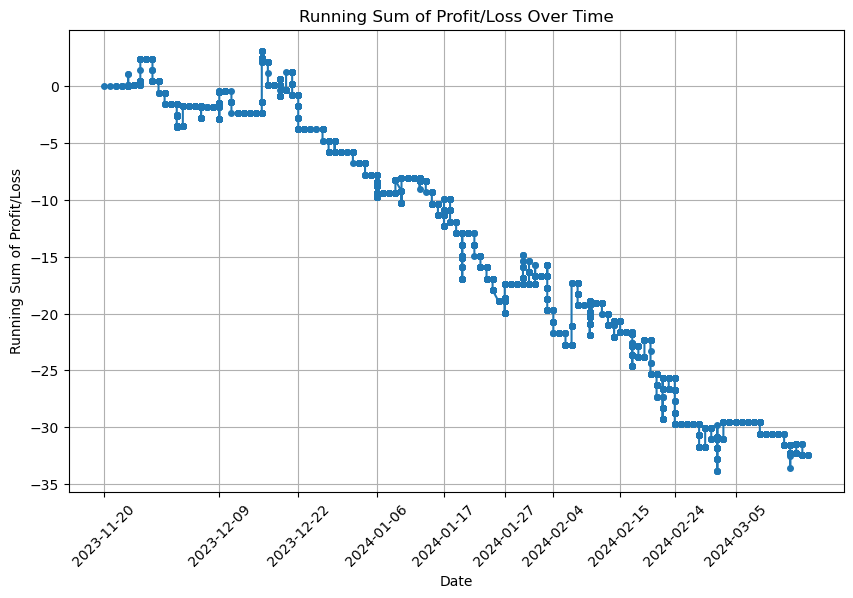

In [15]:
# Plot the Total Profit/Loss vs. Date

plt.figure(figsize=(10, 6))
plt.plot(predictions_df['Date'], predictions_df['Total Profit/Loss'], marker='o', markersize=4)  # Set marker size to 4
plt.title('Running Sum of Profit/Loss Over Time')
plt.xlabel('Date')
plt.ylabel('Running Sum of Profit/Loss')

# Reduce the number of x-axis labels
plt.xticks(predictions_df['Date'][::len(predictions_df)//10], rotation=45)  # Show approximately 10 labels

plt.grid(True)
plt.show()



In [16]:
# search for ideal bet confidence threshold

# Initialize the results DataFrame
results_df = pd.DataFrame(columns=[
    'Threshold', 'Total Bet Amount', 'Total Profit/Loss', 
    'Profit/Loss per Dollar Bet', 'Number of Bets Made', 
    'Number of Bets Won', 'Number of Bets Lost'
])

threshold = 0.00

# initialize flag
no_more_bets = False

while threshold < 1.00:
    
    # verbosity
    print(f'Calculating at threshold = {round(threshold, 2)}')
    
    # set bet amount
    bet_amount = 1

    # create new rows for bets
    predictions_df['Team A Bet Amount'] = 0.0
    predictions_df['Team A Profit/Loss'] = 0.0
    predictions_df['Team B Bet Amount'] = 0.0
    predictions_df['Team B Profit/Loss'] = 0.0
    predictions_df['Bet Amount'] = 0.0
    predictions_df['Profit/Loss'] = 0.0

    # if no bets were made last iteration
    if no_more_bets:
        iteration_results = pd.DataFrame([{
        'Threshold': threshold,
        'Total Bet Amount': 0.0,
        'Total Profit/Loss': 0.0,
        'Profit/Loss per Dollar Bet': 0.0,
        'Number of Bets Made': 0.0,
        'Number of Bets Won': 0.0,
        'Number of Bets Lost': 0.0
    }])
    
    # if bets were made last iteration
    else:
        # iterate through each predicted game
        for index in range(len(predictions_df)):
            # if Team A moneyline exists
            if isinstance(predictions_df.loc[index, 'Team A Implied Prob'], float):
                # if Team A's predicted probability is higher than implied probability by more than the threshold difference
                if predictions_df.loc[index, 'Team A Predicted Prob'] > predictions_df.loc[index, 'Team A Implied Prob'] + threshold:
                    # place a bet on Team A
                    predictions_df.loc[index, 'Team A Bet Amount'] = bet_amount
                    # if Team A actually won
                    if predictions_df.loc[index, 'Actual Result: Team A Wins']:
                        # calculate profit
                        # if positive moneyline
                        if int(predictions_df.loc[index, 'Team A Moneyline']) > 0:
                            predictions_df.loc[index, 'Team A Profit/Loss'] = predictions_df.loc[index, 'Team A Bet Amount'] * int(predictions_df.loc[index, 'Team A Moneyline']) / 100
                        # if negative moneyline
                        elif int(predictions_df.loc[index, 'Team A Moneyline']) < 0:
                            predictions_df.loc[index, 'Team A Profit/Loss'] = -predictions_df.loc[index, 'Team A Bet Amount'] * 100 / int(predictions_df.loc[index, 'Team A Moneyline'])
                    # if Team A actually lost
                    else:
                        # calculate amount lost
                        predictions_df.loc[index, 'Team A Profit/Loss'] = -predictions_df.loc[index, 'Team A Bet Amount']
                # if Team A's predicted probability is not higher than implied probability
                else:
                    # don't place a bet on Team A
                    predictions_df.loc[index, 'Team A Bet Amount'] = 0
                    predictions_df.loc[index, 'Team A Profit/Loss'] = 0
            # if Team A moneyine does not exist
            else:
                # don't place a bet on Team A
                predictions_df.loc[index, 'Team A Bet Amount'] = 0
                predictions_df.loc[index, 'Team A Profit/Loss'] = 0

            # if Team B moneyline exists
            if isinstance(predictions_df.loc[index, 'Team B Implied Prob'], float):
                # if Team B's predicted probability is higher than implied probability by more than the threshold difference
                if predictions_df.loc[index, 'Team B Predicted Prob'] > predictions_df.loc[index, 'Team B Implied Prob'] + threshold:
                    # place a bet on Team B
                    predictions_df.loc[index, 'Team B Bet Amount'] = bet_amount
                    # if Team B actually won
                    if not predictions_df.loc[index, 'Actual Result: Team A Wins']:
                        # calculate profit
                        # if positive moneyline
                        if int(predictions_df.loc[index, 'Team B Moneyline']) > 0:
                            predictions_df.loc[index, 'Team B Profit/Loss'] = predictions_df.loc[index, 'Team B Bet Amount'] * int(predictions_df.loc[index, 'Team B Moneyline']) / 100
                        # if negative moneyline
                        elif int(predictions_df.loc[index, 'Team B Moneyline']) < 0:
                            predictions_df.loc[index, 'Team B Profit/Loss'] = -predictions_df.loc[index, 'Team B Bet Amount'] * 100 / int(predictions_df.loc[index, 'Team B Moneyline'])
                    # if Team B actually lost
                    else:
                        # calculate amount lost
                        predictions_df.loc[index, 'Team B Profit/Loss'] = -predictions_df.loc[index, 'Team B Bet Amount']
                # if Team B's predicted probability is not higher than implied probability
                else:
                    # don't place a bet on Team B
                    predictions_df.loc[index, 'Team B Bet Amount'] = 0
                    predictions_df.loc[index, 'Team B Profit/Loss'] = 0
            # if Team B moneyine does not exist
            else:
                # don't place a bet on Team B
                predictions_df.loc[index, 'Team B Bet Amount'] = 0
                predictions_df.loc[index, 'Team B Profit/Loss'] = 0

            # consolidate bets into single column, profit/loss into single column
            predictions_df.loc[index, 'Bet Amount'] = predictions_df.loc[index, 'Team A Bet Amount'] + predictions_df.loc[index, 'Team B Bet Amount']
            predictions_df.loc[index, 'Profit/Loss'] = predictions_df.loc[index, 'Team A Profit/Loss'] + predictions_df.loc[index, 'Team B Profit/Loss']

        # Calculate metrics
        total_bet_amount = round(predictions_df['Bet Amount'].sum(), 2)
        total_profit_loss = round(predictions_df['Profit/Loss'].sum(), 2)
        profit_loss_per_dollar_bet = round(predictions_df['Profit/Loss'].sum() / predictions_df['Bet Amount'].sum(), 2)
        number_of_bets_made = predictions_df.loc[predictions_df['Bet Amount'] > 0, :].count()['Bet Amount']
        number_of_bets_won = predictions_df.loc[predictions_df['Profit/Loss'] > 0, :].count()['Profit/Loss']
        number_of_bets_lost = predictions_df.loc[predictions_df['Profit/Loss'] < 0, :].count()['Profit/Loss']

        # Create a new DataFrame for the current iteration results
        iteration_results = pd.DataFrame([{
            'Threshold': round(threshold, 2),
            'Total Bet Amount': total_bet_amount,
            'Total Profit/Loss': total_profit_loss,
            'Profit/Loss per Dollar Bet': profit_loss_per_dollar_bet,
            'Number of Bets Made': number_of_bets_made,
            'Number of Bets Won': number_of_bets_won,
            'Number of Bets Lost': number_of_bets_lost
        }])
        
        # update flag
        if predictions_df['Bet Amount'].sum() == 0:
            no_more_bets = True
            iteration_results = pd.DataFrame([{
                'Threshold': threshold,
                'Total Bet Amount': 0.0,
                'Total Profit/Loss': 0.0,
                'Profit/Loss per Dollar Bet': 0.0,
                'Number of Bets Made': 0.0,
                'Number of Bets Won': 0.0,
                'Number of Bets Lost': 0.0
            }])

    # Concatenate the new results with the results_df
    results_df = pd.concat([results_df, iteration_results], ignore_index=True)
    
    # Increment threshold
    threshold += 0.01
    

# display results
pd.set_option('display.max_rows', 120)
results_df['Percentage of Max Profit'] = results_df['Total Profit/Loss'] / results_df['Total Profit/Loss'].max()
results_df.sort_values('Total Profit/Loss', ascending=False)


Calculating at threshold = 0.0


/var/folders/b1/dl1m5mq10r3bnrvc2jnnmmb80000gp/T/ipykernel_54922/3848586140.py:144: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, iteration_results], ignore_index=True)


Calculating at threshold = 0.01
Calculating at threshold = 0.02
Calculating at threshold = 0.03
Calculating at threshold = 0.04
Calculating at threshold = 0.05
Calculating at threshold = 0.06
Calculating at threshold = 0.07
Calculating at threshold = 0.08
Calculating at threshold = 0.09
Calculating at threshold = 0.1
Calculating at threshold = 0.11
Calculating at threshold = 0.12
Calculating at threshold = 0.13
Calculating at threshold = 0.14
Calculating at threshold = 0.15
Calculating at threshold = 0.16
Calculating at threshold = 0.17
Calculating at threshold = 0.18
Calculating at threshold = 0.19
Calculating at threshold = 0.2
Calculating at threshold = 0.21
Calculating at threshold = 0.22
Calculating at threshold = 0.23
Calculating at threshold = 0.24
Calculating at threshold = 0.25
Calculating at threshold = 0.26
Calculating at threshold = 0.27
Calculating at threshold = 0.28
Calculating at threshold = 0.29
Calculating at threshold = 0.3
Calculating at threshold = 0.31
Calculating

/var/folders/b1/dl1m5mq10r3bnrvc2jnnmmb80000gp/T/ipykernel_54922/3848586140.py:114: RuntimeWarning: invalid value encountered in scalar divide
  profit_loss_per_dollar_bet = round(predictions_df['Profit/Loss'].sum() / predictions_df['Bet Amount'].sum(), 2)


,Threshold,Total Bet Amount,Total Profit/Loss,Profit/Loss per Dollar Bet,Number of Bets Made,Number of Bets Won,Number of Bets Lost,Percentage of Max Profit
38,0.38,14.0,4.43,0.32,14,5,9,1.000000
35,0.35,28.0,2.26,0.08,28,10,18,0.510158
37,0.37,19.0,1.73,0.09,19,6,13,0.390519
41,0.41,10.0,1.42,0.14,10,3,7,0.320542
40,0.40,10.0,1.42,0.14,10,3,7,0.320542
34,0.34,31.0,1.26,0.04,31,11,20,0.284424
36,0.36,22.0,1.03,0.05,22,7,15,0.232506
39,0.39,11.0,0.42,0.04,11,3,8,0.094808
32,0.32,47.0,0.34,0.01,47,17,30,0.076749
71,0.71,0.0,0.00,0.00,0.0,0.0,0.0,0.000000


In [19]:
# display bet confidence threshold results for all test seasons

season_thresholds = results_df.loc[:, ['Threshold', 'Percentage of Max Profit']]

try:
    all_thresholds[str(pastSeason)] = season_thresholds['Percentage of Max Profit'].values
    all_thresholds = all_thresholds.drop(columns=['Sum of Percentages of Max Profit'])
    all_thresholds.loc[:, 'Sum of Percentages of Max Profit'] = all_thresholds.sum(axis=1)
    all_thresholds = all_thresholds.sort_values('Sum of Percentages of Max Profit', ascending=False)
except NameError:
    all_thresholds = pd.DataFrame(columns=['Sum of Percentages of Max Profit'])
    all_thresholds[str(pastSeason)] = season_thresholds['Percentage of Max Profit'].values
    all_thresholds = all_thresholds.drop(columns=['Sum of Percentages of Max Profit'])
    all_thresholds.loc[:, 'Sum of Percentages of Max Profit'] = all_thresholds.sum(axis=1)
    all_thresholds = all_thresholds.sort_values('Sum of Percentages of Max Profit', ascending=False)
    
all_thresholds

,2024,Sum of Percentages of Max Profit
38,1.000000,1.000000
35,0.510158,0.510158
37,0.390519,0.390519
41,0.320542,0.320542
40,0.320542,0.320542
34,0.284424,0.284424
36,0.232506,0.232506
39,0.094808,0.094808
32,0.076749,0.076749
71,0.000000,0.000000
